In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg


In [8]:
def wrangle(filepath):

    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Drop a  all column
    df = df.drop(columns=["unix",'symbol','low','open','high','Volume BTC','Volume USD'])


    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set date column as index
    df.set_index("date", inplace=True)

    # Localize timezone
    #df.index = df.index.tz_localize("UTC")

    # Remove outliers
    #df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["close"].resample("1H").mean().fillna(method='ffill')

    return y

In [11]:
y=wrangle(r'C:\Users\Nassoh\Desktop\DataSienceMyProject\BTC Price\Data\BTCUSD_hour.csv')
y

date
2018-05-15 06:00:00     8740.99
2018-05-15 07:00:00     8739.00
2018-05-15 08:00:00     8728.49
2018-05-15 09:00:00     8708.32
2018-05-15 10:00:00     8795.90
                         ...   
2023-04-24 20:00:00    27453.00
2023-04-24 21:00:00    27414.00
2023-04-24 22:00:00    27468.00
2023-04-24 23:00:00    27512.00
2023-04-25 00:00:00    27499.00
Freq: H, Name: close, Length: 43339, dtype: float64

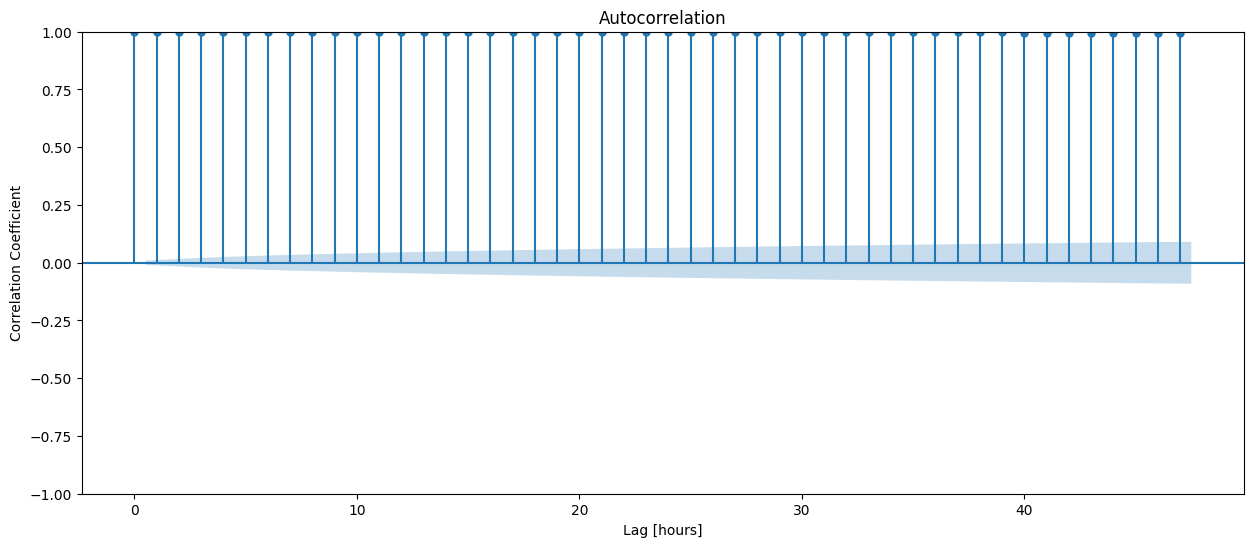

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.show()

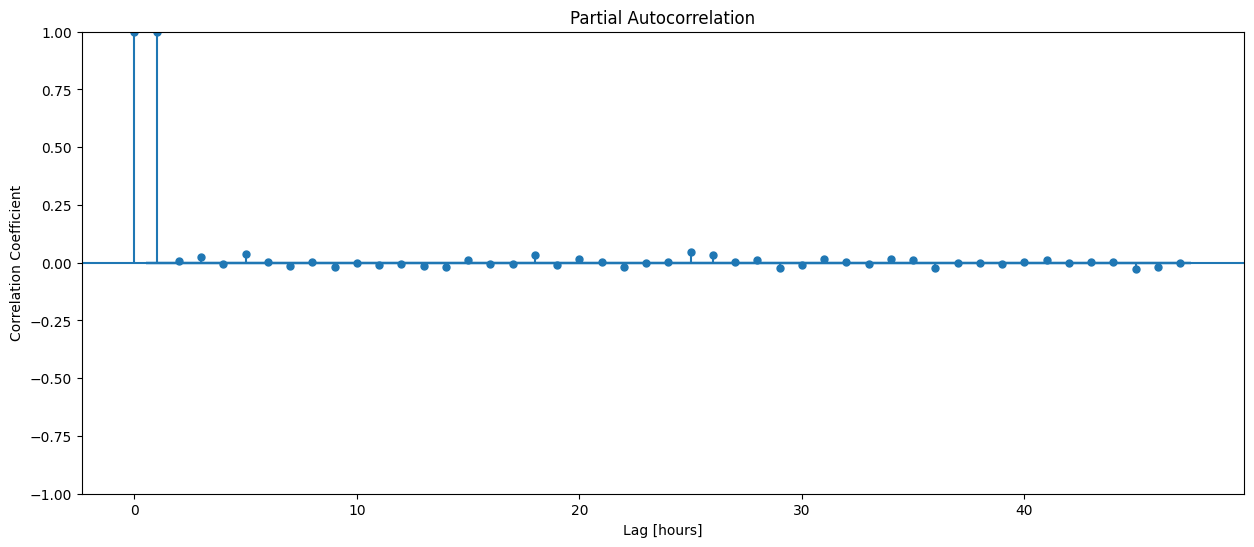

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");
plt.show()

# Split

In [19]:
cutoff_test =int(len(y)*0.95)

y_train =y.iloc[:cutoff_test]
y_test =y.iloc[cutoff_test:]

# Baseline

In [21]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean BTC Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean BTC Reading: 21117.82
Baseline MAE: 14686.1


# Build Model

In [41]:
model =AutoReg(y_train,lags=26).fit()

In [42]:
print(model.params)

const        2.109723
close.L1     0.993558
close.L2    -0.013958
close.L3     0.024700
close.L4    -0.034762
close.L5     0.029439
close.L6     0.015446
close.L7    -0.017667
close.L8     0.017408
close.L9    -0.011802
close.L10    0.004710
close.L11   -0.000620
close.L12    0.006323
close.L13    0.000512
close.L14   -0.023177
close.L15    0.012681
close.L16    0.002541
close.L17   -0.032459
close.L18    0.033906
close.L19   -0.021461
close.L20    0.011019
close.L21    0.017640
close.L22   -0.012535
close.L23   -0.004543
close.L24   -0.036398
close.L25    0.013150
close.L26    0.026265
dtype: float64


# Evaluate

In [24]:
y_pred =model.predict().dropna()
training_mae =mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)
print("Baseline MAE:", round(mae_baseline, 2))

Training MAE: 107.73645877857824
Baseline MAE: 14686.1


In [25]:
y_train_resid =model.resid
y_train_resid.tail()

date
2023-01-24 13:00:00   -115.118880
2023-01-24 14:00:00    -13.757067
2023-01-24 15:00:00     71.168290
2023-01-24 16:00:00    -40.857212
2023-01-24 17:00:00     42.572168
Freq: H, dtype: float64

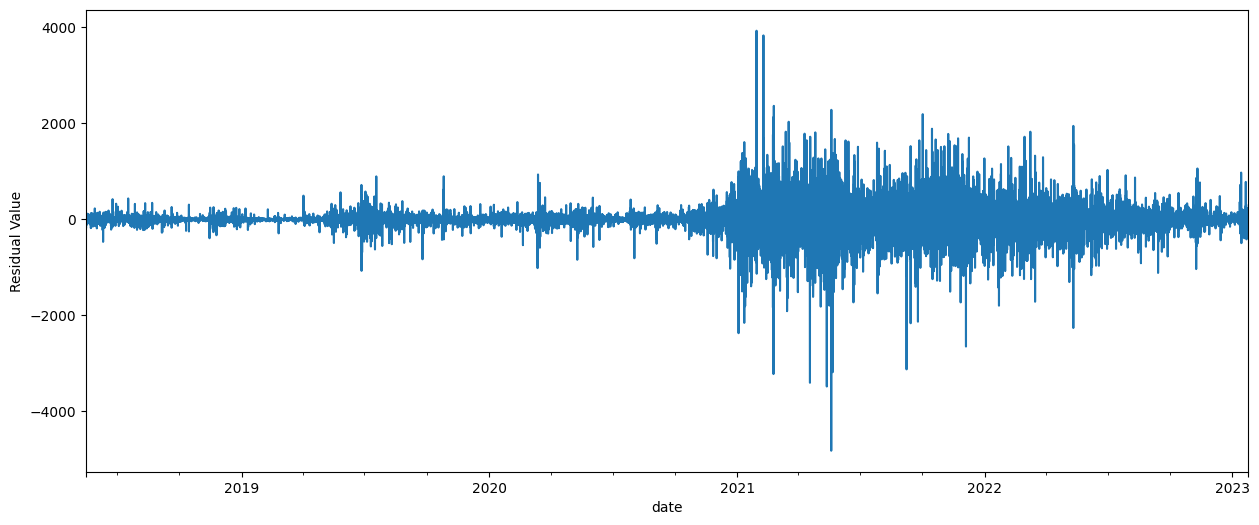

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel='Residual Value',ax=ax)
plt.show()

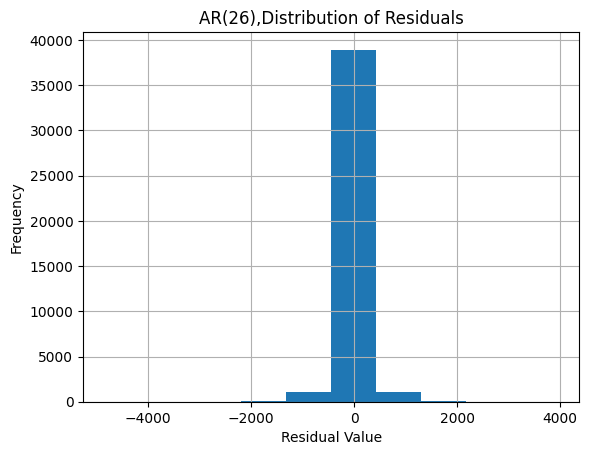

In [29]:
y_train_resid.hist()
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('AR(26),Distribution of Residuals')
plt.show()

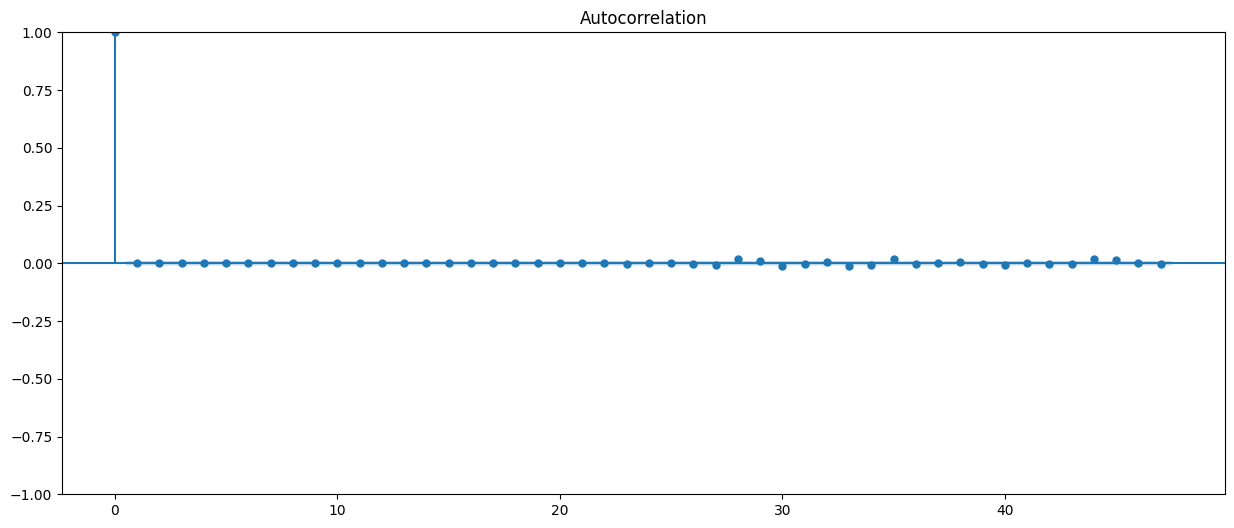

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)

In [32]:
y_pred_test =model.predict(y_test.index.min(),y_test.index.max())
test_mae =mean_absolute_error(y_test,y_pred_test)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)

Baseline MAE: 14686.1
Training MAE: 107.73645877857824
Test MAE: 2724.434323256489


In [36]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)
df_pred_test

,y_test,y_pred
date,,
2023-01-24 18:00:00,23003.0,22915.256344
2023-01-24 19:00:00,23026.0,22916.881684
2023-01-24 20:00:00,23022.0,22910.251002
2023-01-24 21:00:00,22902.0,22904.215248
2023-01-24 22:00:00,22763.0,22905.151452
...,...,...
2023-04-24 20:00:00,27453.0,23354.258739
2023-04-24 21:00:00,27414.0,23354.446253
2023-04-24 22:00:00,27468.0,23354.633753


In [37]:
fig = px.line(df_pred_test, labels={"value": "BTC"})
fig.show()

In [38]:
%%capture

y_pred_wfv =pd.Series()
history =y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=26).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])
    
    pass

In [39]:
test_mae_w=mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae_w, 2))

Test MAE (walk forward validation): 85.17


In [40]:
print(model.params)

const        2.226785
close.L1     0.993077
close.L2    -0.012553
close.L3     0.023884
close.L4    -0.033757
close.L5     0.027739
close.L6     0.015081
close.L7    -0.016862
close.L8     0.016982
close.L9    -0.010698
close.L10    0.003824
close.L11   -0.000004
close.L12    0.006073
close.L13    0.000587
close.L14   -0.021777
close.L15    0.011331
close.L16    0.002248
close.L17   -0.031528
close.L18    0.033850
close.L19   -0.021444
close.L20    0.010507
close.L21    0.017294
close.L22   -0.011610
close.L23   -0.004967
close.L24   -0.035907
close.L25    0.012218
close.L26    0.026330
dtype: float64


In [44]:
df_pred_test_wfv = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_wfv}
)

fig = px.line(df_pred_test_wfv, labels={"value": "BTC"})
fig.show()